## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

Performing A/B tests on the data from site to analyze if the new page is better in terms of conversion when compared to old page. if better how significantly better.<br>

**Out of scope factors** that are usually considered for such analysis, 1) cost of rolling out new page. 2) backend technology improvements that benefits business but does not factor into user experience of the site 

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [198]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [199]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [200]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [201]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [202]:
df['group'].unique()

array(['control', 'treatment'], dtype=object)

d. The proportion of users converted.

In [203]:
converted_proportion = df['converted'].mean()
print(converted_proportion)

0.119659193556


e. The number of times the `new_page` and `treatment` don't match.

In [204]:
mismatch = df[(df['group']=="treatment") & (df['landing_page']!="new_page")|(df['group']!="treatment") & (df['landing_page']=="new_page")]
mismatch.shape[0]

3893

In [205]:
mismatch.shape[0]/df.shape[0]

0.013220002852505111

f. Do any of the rows have missing values?

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**No there are no missing values in this dataset**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

In [207]:
df2 = df[(df['group']=="treatment") & (df['landing_page']=="new_page")|(df['group']=="control") & (df['landing_page']=="old_page")]

**Carving out the dataframe where treatment group is presented with new page OR control group presented with old page**

In [208]:
df2.shape

(290585, 5)

In [209]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [210]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

Based on the below output the user_id is **773192**

c. What is the row information for the repeat **user_id**? 

In [211]:
df2[df2.duplicated(['user_id'],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [212]:
df2.drop_duplicates(subset='user_id',keep="first", inplace=True)
df2.nunique()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

a. What is the probability of an individual converting regardless of the page they receive?

In [213]:
converted_proportion = df2['converted'].mean()
converted_proportion

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [214]:
control_conv = df2[df2['group']=="control"]['converted'].mean()

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [215]:
treatment_conv =df2[df2['group']=="treatment"]['converted'].mean()

d. What is the probability that an individual received the new page?

In [216]:
prob_np = df2[df2['landing_page']=="new_page"].shape[0] / df2.shape[0]
prob_np

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [217]:
obs_diff = treatment_conv - control_conv
obs_diff

-0.0015782389853555567

**Answer** <br>
1) About 50% of users were presented with new page<br>
2) The % people converted from new page (11.8%) is slightly lesser than that for for old page (12%)<br>
Based on the above 2 observations, i infer there is no sufficient evidenc to conclude new page leads to more conversions

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general. 

**Observation** Currently timestamp variable is not taken into the analysis also agree that it might be a important factor in conversion.   


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer** <br> Null hypothesis: The old page has better/equal conversion rate as new page
Alternate hypothesis: The new page has better conversion rate than old page

$H_0:  $p_{old}  $ >=   $p_{new}$  $

$H_1:  $p_{new}$   >   $p_{old}$  $

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [218]:
p_new = converted_proportion
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [219]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [220]:
n_new = df2[df2['group']=='treatment'].user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [221]:
n_old = df2[df2['group']=='control'].user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [222]:
new_page_converted = np.random.choice([0,1],n_new, p=((1-p_new),p_new))

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [223]:
old_page_converted = np.random.choice([0,1],n_old, p=((1-p_old),p_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [224]:
(new_page_converted).mean() - (old_page_converted).mean()

-0.0010208356209199798

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [225]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

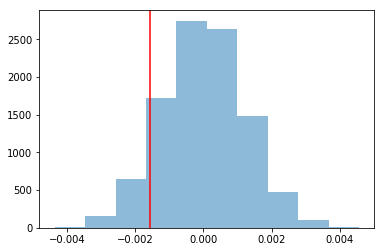

In [226]:
plt.hist(p_diffs,alpha=0.5)
plt.axvline(x=obs_diff, color = 'red');

**Observation** p_diffs represent the array of difference in simulated conversion rate between new page users & old page users. The red line indicates the actual difference from the data set. I expected the line to be closer to center

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [227]:
(p_diffs > obs_diff).mean()

0.90229999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer** <br>With P value of greater than 90%, it is very likely that our statistic is from null. The difference in the conversion rate of old page and new page appears not to be significant enough to reject the null hypothesis

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [228]:
import statsmodels.api as sm

convert_old = df2[df2['group']=="control"]['converted'].sum()
convert_new = df2[df2['group']=="treatment"]['converted'].sum()
n_old = df2[df2['group']=='treatment'].user_id.count()
n_new = df2[df2['group']=='control'].user_id.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [229]:
from scipy.stats import norm
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative="smaller")
print("z_score = {} , p_value = {}".format(round(z_score,2),round(p_value,2)))

z_score = 1.26 , p_value = 0.9


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer** <br>
1) P Value (.89) is fairly close to the value found by the methods from **j.** and **k.** (.90)<br>
2) z score of 1.26 signifies that the new page conversion rate is less than the crtical value of 95% confidence interval. This reinforces the finding from above that we cannot reject the null hypothesis 

<a id='regression'></a>
### Part III - A regression approach


a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer** <br>Since there are 2 possible outcomes, logistic regression can be a good approach to do the A/B Test

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [230]:
df2[['ab_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept']=1
df2 = df2.drop('old_page', axis=1)
df2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [231]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [232]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-25 18:06 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [233]:
1/np.exp(-0.0150)

1.0151130646157189

**Observation** Based on the reciprocal of exponentiated value of new_page coefficient, the conversation rate in new page decreases by 1.015 times when compared to the old page

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**? 

**Answer**<br>
pvalue is 0.18 and greater than our threshold, hence we cannot reject the null hypothesis. because the logistic regression here is setup as two tailed test the pvalue is different from the previous method which was setup as one tailed test.

**Logistic regression** <br>
null hypotheses - pnew = pold<br>
alternate hypotheses = pnew != pold<br>

**Part 2 method (based on binomial)**<br>
null hypotheses - pold >= pnew<br>
alternate hypotheses = pnew > pold<br>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer** <br>
Other factors that can be considered for influence on conversions are

1) Derived from timestamp<br>
2) Time of the day - morning, afternoon and evening<br>
3) Weekday vs weekend<br>
4) Month of the visit<br>

g. Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - 

In [234]:
countries = pd.read_csv('countries.csv')
df3 = pd.merge(df2, countries, on='user_id', how='inner')

In [235]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
#df3.drop('US', axis=1)
df3.head(2)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1


In [236]:
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page','CA','UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-25 18:06 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**AB page factor holding all others as constant**

In [237]:
1/np.exp(-0.0149)

1.0150115583846535

**CA country Factor holding all others as constant**

In [238]:
1/np.exp(-0.0408)

1.0416437559600236

**UK country Factor holding all others as constant**

In [239]:
np.exp(0.0099)

1.0099491671175422

**Answer** <br>
As per above observations, the country variable does not seem to a significant factor for conversions as a standalone factor. Maybe collinearity might play a role (country + page presented)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [240]:
df3["ca_page"] = df3["ab_page"]*df3["CA"]
df3["uk_page"] = df3["ab_page"]*df3["UK"]
df3["us_page"] = df3["ab_page"]*df3["US"]

In [241]:
log_mod2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page','CA','UK','ca_page','uk_page']])
results = log_mod2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-25 18:06 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ca_page      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
uk_page       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

**CA - Interaction variable with country and page presented**

In [242]:
1/np.exp(-0.0469)

1.0480172021191829

For users from CA presented with new page, The chance of conversion decreases by 1.04 times as compared to the users in US

**UK - Interaction variable with country and page presented**

In [243]:
np.exp(0.0314)

1.0318981806179213

For users from US presented with new page, The chance of conversion decreases by 1.03 times as compared to the users in US

<a id='conclusions'></a>
## Finishing Up

> **Part 1 - conclusions** <br>
1) There are 2 groups in this experiment control group presented with old page and treatment group presented with new page. The proportion of treament group is about 50% which is a significant number of data to analyze one <br>
2) Based on the population data, the observed difference between conversion rate of treatment group (11.8%) and control group (12%) is **-0.15%**.  <br>

> **Part 2 - conclusions** <br>
1) Null hypotheses is that coversions from old page are greater than or equal to new page while alternate hypotheses is that conversions from new page is higher than old page setting up one tailed test <br>
2) We are assuming the conversaion rate of old and new page to be equal under the null which is **11.95%**.  <br>
3) Converted number of people is almost equally distributed with both groups
4) post simulation with binomial function, it was observed that more 90% of the p_diffs values were above the observed difference. Hence we **cannot** reject the null hypothesis
5) on using in built function stats.proportions_ztest to compute z score and p value (z_score = 1.26 , p_value = 0.9) , the above conclusion of holding the null hypotheses as true is reinforced. Z value also signifies that the new page conversion rate is less than the crtical value of 95% confidence interval

> **Part 3 - conclusions** <br>
1) Based on the reciprocal of exponentiated value of new_page coefficient from logistic regression, the conversation rate in new page decreases by 1.015 times when compared to the old page <br>
2) pvalue is 0.18 and greater than our threshold, hence we cannot reject the null hypothesis. because the logistic regression here is setup as two tailed test the pvalue is different from the previous method which was setup as one tailed test.<br>
3) Adding country factor, it was observed that within the 3 countries there was not a significant difference in terms of chances of coversion (CA times factor vs US = 1.04 & UK times factor vs US = 1.01 ) <br>
4) When interaction with page and country is consider, it again did not make significant difference to the above inference. (CA_page times factor vs US = 1.04 & UK_page times factor vs US = 1.03 (a very slight improved from above) )

> **Final conclusions** <br>
1) Based on above observations & within the factors analyzed, it can be concluded that rolling out new page will not make a significant positive impact to conversion rate
2) Country as a factor is not providing significant differentiation to conversion rate, either independantly or as a combination variable with page

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [244]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0